<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/250526_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝 파이토치 교과서

## 5.3 전이 학습
전이 학습이란 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미한다. 이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사정 훈련된 모델이라고 한다.

### 5.3.1 특성 추출 기법
특성 추출은 학습할 때는 마지막 완전 연결층만 학습하고 나머지 계층들은 학습되지 않도록한다.

- 합성곱층: 합성곱층과 풀링층으로 구성
- 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

사전 훈련된 네트워크의 합성곱층에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킨다.

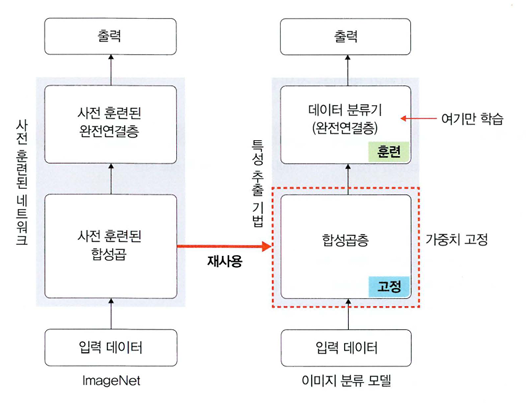



In [1]:
pip install opencv-python

In [2]:
import os
import time
import copy
import glob
import cv2 # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap05/data/catanddog/

# 3. 파일 목록 확인
!ls

fatal: destination path '080289' already exists and is not an empty directory.
/content/080289/chap05/data/catanddog
00.pth	02.pth	04.pth	06.pth	08.pth	10.pth	12.pth	train
01.pth	03.pth	05.pth	07.pth	09.pth	11.pth	test


In [4]:
# 이미지 데이터 전처리 방법 정의
data_path = '/content/080289/chap05/data/catanddog/train' # 이미지 데이터가 위치한 경로 지정

transform = transforms.Compose(
    [transforms.Resize([256, 256]),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()
     ]
) # torchvision.transform은 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환해준다.
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
) # 데이터 로더가 데이터를 불러올 대상과 방법을 정의한다.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
) # 데이터를 불러오는 부분

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


+) RandomResizedCrop 자세히 알아보기

pip install mnet

pip install --user mxnet
으로 설치

오류가 발생할 수 있으나, 그것은 넘파이 버전과 호환성에 문제가 있다는 문구로 호환되는 넘파이 버전으로 재설치됨.

데이터 확장 코드

import matplotlib.pyplot as plt

import mxnet as mx

from mxnet.gluon.data.vision import transforms


example_image = mx.image.imread("../chap05/data/cat.jpg") # 예제를 진행할 이미지 불러오기

plt.imshow(example_image.asnumpy()) # 불러온 이미지 출력

불러온 이미지에 RandomResizedCrop을 적용하기 위한 함수를 생성하고 RandomResizedCrop이 적용된 이미지를 출력하면
너비와 비율을 조절하고 scale을 통해 자른 뒤의 이미지가 보여진다.

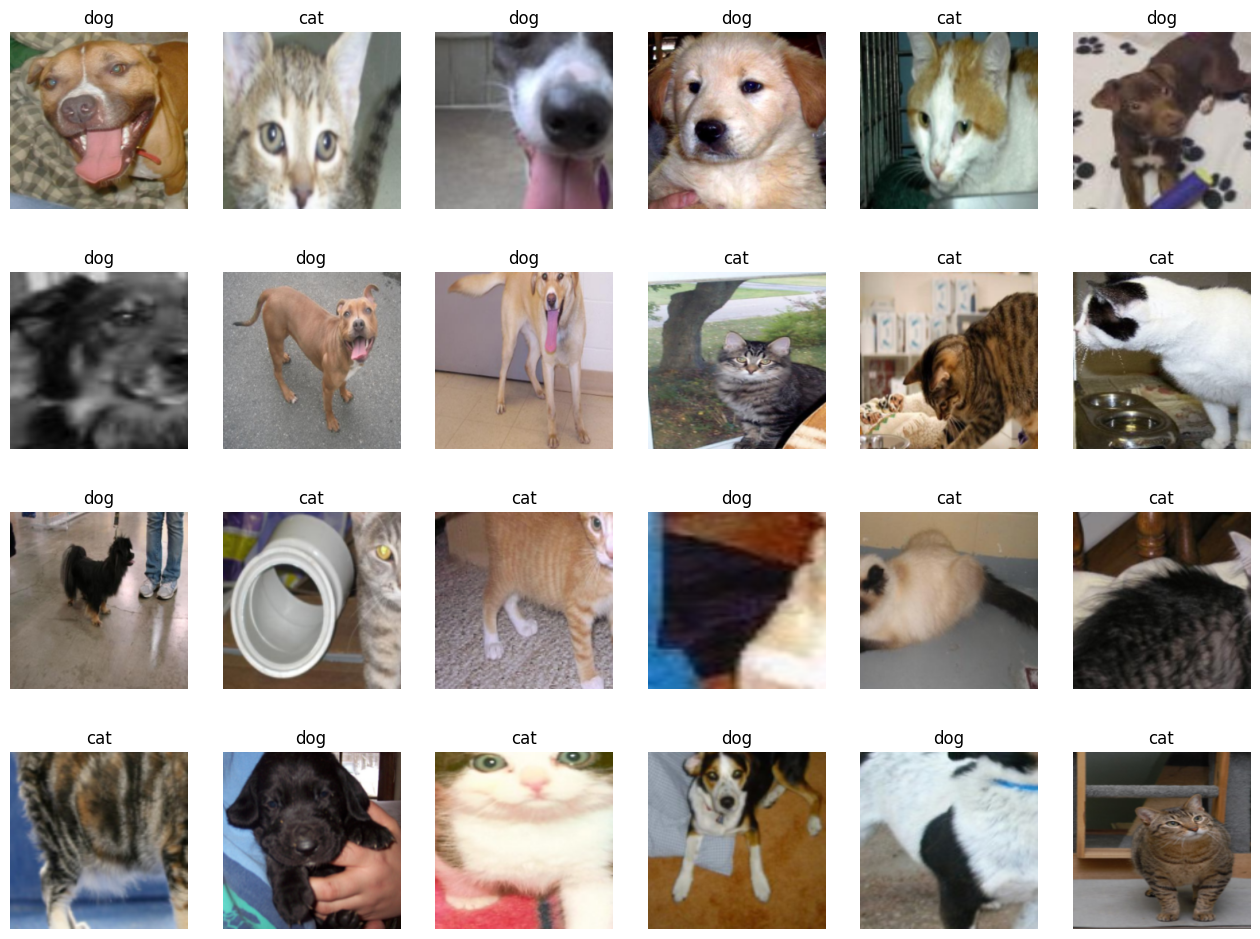

In [5]:
# 학습에 사용될 이미지 출력
import numpy as np

samples, labels = next(iter(train_loader)) # iter는 전달된 데이터의 반복자를 꺼내 반환하며, next는 그 방복자가 다음에 출력해야 할 요소를 반환한다.
classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16, 24))
for i in range(24): # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True) # pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


+) ResNet18

ResNet은 50개 계층으로 구성된 합성곱 신경망이다. ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망으로  전이 학습에 사용되도록 사전 훈련된 모델을 제공하고 있다.

+) 사전 훈련된 모델

파이토치는 다음과 같은 방법으로 무작위의 가중치로 모델을 구성할 수 있다.

import torchvision.models as models

resnet18 = models.resnet18()

또한, 다음과 같은 방법을 이용하여 사전 학습된 모델을 사용할 수 있다.

import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)

In [7]:
# 내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정시킨다.
# 사전 훈련된 모델의 파라미터 학습 유뮤 지정
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False # 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음을 나타낸다.

set_parameter_requires_grad(resnet18)

In [8]:
# ResNet18에 완전연결층 추가
# 추가된 완전연결층은 개와 고양이 클래스를 분류하는 용도로 사용된다.
resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 두 개라는 의미

In [9]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용.
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[ 0.0066,  0.0280, -0.0362,  ...,  0.0165,  0.0398,  0.0174],
        [-0.0143, -0.0408,  0.0156,  ..., -0.0141, -0.0234, -0.0053]])
fc.bias tensor([0.0414, 0.0417])


In [10]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
  since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs): # 에포크(13)만큼 반복
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders: # 데이터로더에 전된 데이터만큼 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad() # 기울기를 0으로 설정
      outputs = model(inputs) # 순전파 학습
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      loss.backward() # 역전파 학습
      optimizer.step()

      running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
      running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

    epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
    epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장해둔다.
    print()

  time_elapsed = time.time() - since # 실행 시간을 계산
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Acc: {:4f}'.format(best_acc))
  return acc_history, loss_history # 모델의 정확도와 오차를 반환

그리고 마지막으로 ResNet18에 추가된 완전연결층은 학습을 하도록 설정한다. 학습을 통해 얻어지는 파라미터를 옵티마이저에 젆달해서 최종적으로 모델 학습에 사용한다.

In [12]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param) # 파라미터 학습 결과를 저장
    print("\t", name)

optimizer = optim.Adam(params_to_update) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


weight와 bias 값들이 업데이트되고 옵티마이저에 전달된다.

In [13]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6518 Acc: 0.6026

Epoch 1/12
----------
Loss: 0.4487 Acc: 0.8000

Epoch 2/12
----------
Loss: 0.3628 Acc: 0.8571

Epoch 3/12
----------
Loss: 0.2693 Acc: 0.9247

Epoch 4/12
----------
Loss: 0.2972 Acc: 0.8753

Epoch 5/12
----------
Loss: 0.2268 Acc: 0.9351

Epoch 6/12
----------
Loss: 0.2548 Acc: 0.8961

Epoch 7/12
----------
Loss: 0.2113 Acc: 0.9247

Epoch 8/12
----------
Loss: 0.2758 Acc: 0.8883

Epoch 9/12
----------
Loss: 0.2064 Acc: 0.9143

Epoch 10/12
----------
Loss: 0.2012 Acc: 0.9325

Epoch 11/12
----------
Loss: 0.2496 Acc: 0.8701

Epoch 12/12
----------
Loss: 0.2814 Acc: 0.8623

Training complete in 8m 42s
Best Acc: 0.935065


약 93%로 상당히 높은 정확도를 보여주고 있다. 훈련 데이터로는 학습이 잘되었다고 할 수 있다. 이제 테스트 용도의 데이터를 이용하여 모델 정확도를 측정해 보아야 한다.

In [14]:
# 테스트 데이터 호출 및 전처리
test_path = '/content/080289/chap05/data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(244),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [15]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('/content/080289/chap05/data/catanddog/' + '*.pth') # 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용
  saved_models.sort() # 불러온 .pth 파일들을 정렬
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders: # 테스트 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
        outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장

      _, preds = torch.max(outputs.data, 1) # 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환
      preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
      preds[preds < 0.5] = 0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
      running_corrects += preds.eq(labels.cpu()).int().sum() # preds 배열과 labels가 일치하는지 검사하는 용도로 사용.

    epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      acc_history.append(epoch_acc.item())
      print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history # 계산된 정확도 반환

In [16]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/080289/chap05/data/catanddog/00.pth', '/content/080289/chap05/data/catanddog/01.pth', '/content/080289/chap05/data/catanddog/02.pth', '/content/080289/chap05/data/catanddog/03.pth', '/content/080289/chap05/data/catanddog/04.pth', '/content/080289/chap05/data/catanddog/05.pth', '/content/080289/chap05/data/catanddog/06.pth', '/content/080289/chap05/data/catanddog/07.pth', '/content/080289/chap05/data/catanddog/08.pth', '/content/080289/chap05/data/catanddog/09.pth', '/content/080289/chap05/data/catanddog/10.pth', '/content/080289/chap05/data/catanddog/11.pth', '/content/080289/chap05/data/catanddog/12.pth']
Loading model /content/080289/chap05/data/catanddog/00.pth
Acc: 0.8163

Validation complete in 0m 9s
Best Acc: 0.816327


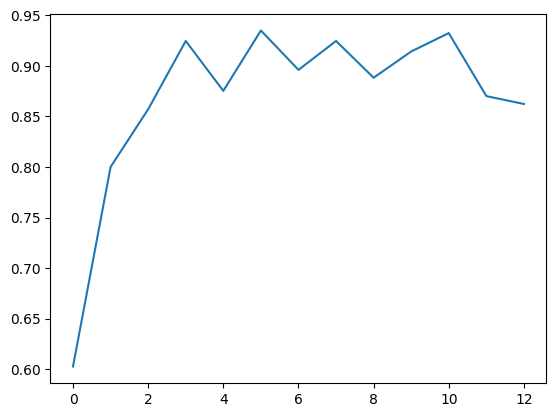

In [17]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

훈련과 테스트 데이터 모두 에포크가 진행될수록 정확도가 높아지면서 100% 가까워지고 있다.

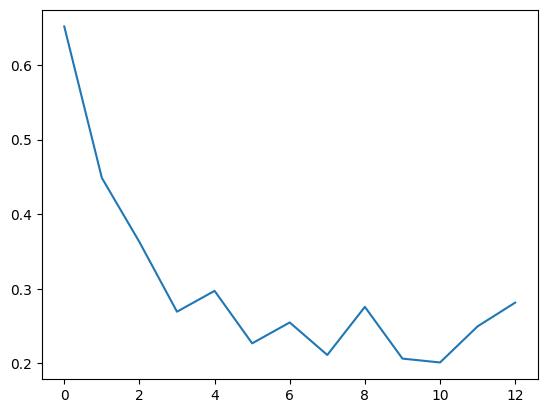

In [18]:
# 훈련 데이터의 오파에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

에포크가 진행될수록 오차가 낮아지고 있다.

실제로 데이터를 잘 예측하는지 살펴보자.

In [21]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
  image = tensor.clone().detach().numpy() # 기존 텐서를 복사한 세로운 텐서를 생성하지만 기울기에 영향을 주지는 않겠다는 의미
  image = image.transpose(1, 2, 0)
  image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1) # 입력 값이 주어진 범위를 벗어날 때 입력값을 특정 법위로 제한시키기 위해 사용함.
  return image

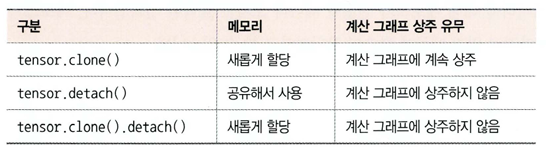

+) 계산 그래프

계산 그래프란 계산 과정을 그래프로 나타낸 것.

- 국소적 계산이 가능하다.
- 역전파를 통한 미분 계산이 편리하다.

+) 연쇄 법칙


합성 함수의 미분법을 연쇄 법칙, 혹은 체인룰이라고 한다.

이제 테스트 데이터셋을 이용하여 실제로도 개와 고양이를 잘 분류하는지 살펴보자.

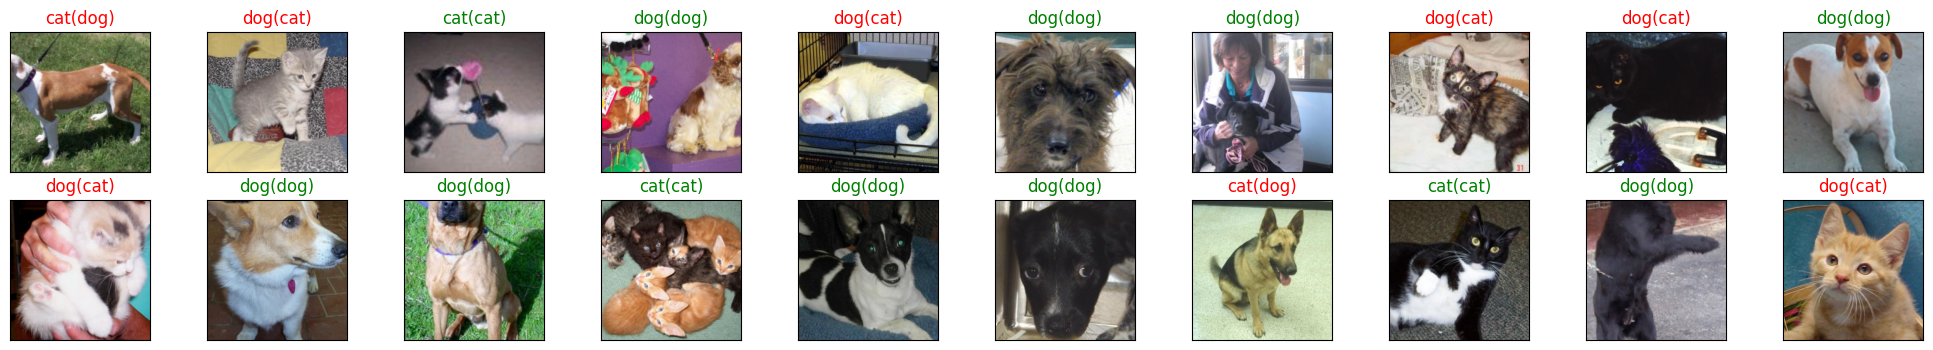

<Figure size 640x480 with 0 Axes>

In [24]:
# 개와 고양이 예측 결과 출력
classes = {0:'cat', 1:'dog'} # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader) # 테스트 데이터셋을 가져온다.
images, labels = next(dataiter) # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져온다.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # 한 화면에 여러개의 이미지를 담기 위해 사용
    plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 im_convert 함수를 적용
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red")) # classes[preds[idx].item()]은 preds[idx].item()값이 classes로 정의된 0괴 1중 어떤 값을 갖는지 판별하겠다는 의미이다.
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0) # 서브플롯의 위치를 조정할 때 사용한다.

개와 고양이에 대한 예측 결과이다. 초록생은 개와 고양이를 정확하게 예측한 것이고, 빨간색은 예측이 잘못되었음을 의미한다.

결과를 살펴보니 예측이 정확하지 않은 것을 확인할 수 있다. 데이터를 더 늘리거나 에포크 횟수도 늘려보면 더 좋은 결과를 얻을 수 있을 것이다.

### 5.3.2 미세 조정 기법
미세 조정 기법은 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식이다. 즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것이다.

미세 조정 기법 전략
- 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우: 모델 전체를 재학습시킨다.
- 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우: 합성곱층의 뒷부분과 데이터 분류기를 학습시킨다.
- 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우: 합성곱층의 일부분과 데이터 분류기를 학습시킨다.
- 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우: 데이터 분류기만 학습시킨다.

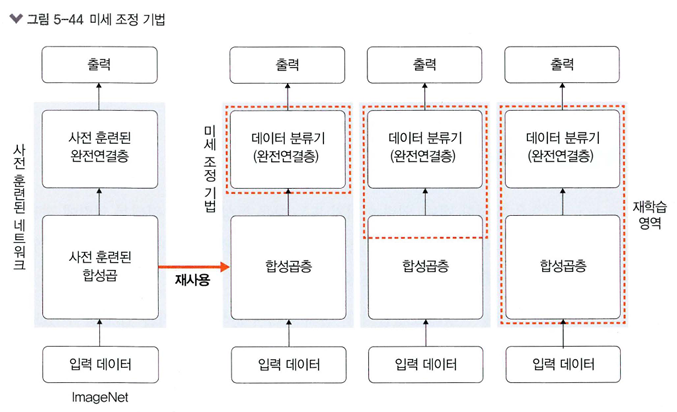